In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
#import category_encoders as ce
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
#pip install --upgrade numpy

In [2]:
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

In [33]:
def train_xgb_model(parameters):
    model = xgb.XGBRegressor(n_estimators = parameters['n_estimator'],objective = parameters['objective'], colsample_bytree = parameters['colsample_bytree'], learning_rate = parameters['learning_rate'],
                max_depth = parameters['max_depth'], alpha = parameters['alpha'])
    return model
def fit_model(model,X_train,y_train):
    model.fit(X_train,y_train)
    
def predict_results(model,X):
    predicted_values = model.predict(X)
    return predicted_values
    
def calculate_rmse(model,y_actual,y_predicted):
    rmse = np.sqrt(mean_squared_error(y_actual,y_predicted))
    return rmse
    
def retune_model(model,hyperparameter_grid,X_train,y_train):
        
        grid_search_cv = RandomizedSearchCV(
        estimator=model,
        param_distributions=hyperparameter_grid,
        cv=10,n_iter=100,
        scoring = 'neg_mean_absolute_error',
        n_jobs=4,
        verbose=5,
        return_train_score=True,
        random_state=42
        )
        grid_search_cv.fit(X_train,y_train)
        return grid_search_cv
    

In [4]:
def pre_process(train_df):
    train_df['LotFrontage'] = train_df['LotFrontage'].fillna(0)
    train_df['Alley'].fillna(0,inplace=True)
    train_df['MasVnrType'].fillna('None',inplace=True)
    train_df['MasVnrArea'].fillna(0,inplace=True)
    
    train_df['BsmtQual'].fillna('NA',inplace=True)
    train_df['BsmtCond'].fillna('NA',inplace=True)
    train_df['BsmtExposure'].fillna('NA',inplace=True)
    train_df['BsmtFinType1'].fillna('NA',inplace=True)
    train_df['BsmtFinType2'].fillna('NA',inplace=True)
    basement_cols = ['BsmtQual','BsmtCond', 'BsmtExposure' , 'BsmtFinType1' , 'BsmtFinType2']
    train_df[basement_cols].any().fillna('NA',inplace=True)
    train_df['Electrical'].fillna('SBrkr',inplace=True)
    train_df['FireplaceQu'].fillna('NA',inplace=True)
    
    garage_columns = ['GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond' ]
    
    train_df['GarageType'].fillna('NA',inplace=True)
    train_df['GarageYrBlt'].fillna('NA',inplace=True)
    train_df['GarageFinish'].fillna('NA',inplace=True)
    train_df['GarageQual'].fillna('NA',inplace=True)
    train_df['GarageCond'].fillna('NA',inplace=True)
    train_df[garage_columns].fillna('NA',inplace=True)
    
    train_df['PoolQC'].fillna('NA', inplace=True)
    train_df['Fence'].fillna('NA', inplace=True)
    train_df['MiscFeature'].fillna('NA',inplace=True)
    
    
    #Encoding related to Basement Feature categories
    BsmtQual_enc = {'Ex':7,'Gd':5,'TA':4,'Fa':3,'Po':2,'NA':1}
    BsmtCond_enc = {'Ex':7,'Gd':5,'TA':4,'Fa':3,'Po':2,'NA':1}
    BsmtExposure_enc = {'Gd':6,'Av':4,'Mn':3,'No':2,'NA':1}
    BsmtFinType1_enc = {'GLQ':7,'ALQ':6,'BLQ':5,'Rec':4,'LwQ':3,'Unf':2,'NA':1}
    BsmtFinType2_enc = {'GLQ':7,'ALQ':6,'BLQ':5,'Rec':4,'LwQ':3,'Unf':2,'NA':1}

    
        #HeatingConditions Encoding
    HeatingQC_enc = {'Ex':10,'Gd':4,'TA':3,'Fa':3,'Po':1}
    Heating_enc = {'Floor':6,'GasA':5,'GasW':4,'Grav':3,'OthW':2,'Wall':1}
    CentralAir_enc = {'Y':2,'N':1}

    #Encoding For Kitchen Quality
    KitchenQual_enc = {'Ex':10,'Gd':4,'TA':3,'Fa':2,'Po':1}
    
    Functional_enc = {'Typ':8,'Min1':7,'Min2':6,'Mod':5,'Maj1':4,'Maj2':3,'Sev':1,'Sal':2}
    
    #FireplaceEncoding
    FireplaceQu_enc = {'Ex':10,'Gd':5,'TA':4,'Fa':3,'Po':2,'NA':1}
    
    #Garage Encoding
    GarageType_enc = {'2Types':10,'Attchd':6,'Basment':5,'BuiltIn':4,'CarPort':3,'Detchd':2,'NA':1}
    GarageFinish_enc = {'Fin':10,'RFn':5,'Unf':2,'NA':1}
    GarageQual_enc = {'Ex':10,'Gd':6,'TA':5,'Fa':4,'Po':3,'NA':1}
    GarageCond_enc = {'Ex':10,'Gd':5,'TA':4,'Fa':3,'Po':2,'NA':1}
    
    
        #Pool Encoding
    PoolQC_enc = {'Ex':10,'Gd':5,'TA':3,'Fa':2,'NA':1}
    #External_condition
    ExterQual_enc = {'Ex':10,'Gd':5,'TA':3,'Fa':2,'Po':1}
    ExterCond_enc = {'Ex':10,'Gd':5,'TA':3,'Fa':2,'Po':1}
    
    Street_enc = {'Grvl':1,'Pave':2}
    Alley_enc = {'Grvl':2,'Pave':4,'NA':1}
    LotShape_enc = {'Reg':6,'IR1':3, 'IR2':2,'IR3':1}
    LandContour_enc = {'Lvl':6 ,'Bnk':3,'HLS':2,'Low':1}
    Utilities_enc = {'AllPub':6,'NoSewr':3,'NoSeWa':2,'ELO':1}

    LandSlope_enc = {'Gtl':4,'Mod':2,'Sev':1}
    PavedDrive_enc = {'Y':4,'P':2,'N':1}
    
    #Copy dataset to a new variable and then encode it
    train_df_encoded = train_df.copy()
    
    #Basement Features encoding
    train_df_encoded['BsmtQual'] = train_df_encoded['BsmtQual'].map(BsmtQual_enc)
    train_df_encoded['BsmtCond'] = train_df_encoded['BsmtCond'].map(BsmtCond_enc)
    train_df_encoded['BsmtExposure'] = train_df_encoded['BsmtExposure'].map(BsmtExposure_enc)
    train_df_encoded['BsmtFinType1'] = train_df_encoded['BsmtFinType1'].map(BsmtFinType1_enc)
    train_df_encoded['BsmtFinType2'] = train_df_encoded['BsmtFinType2'].map(BsmtFinType2_enc)

    #HeatingConditions Encoding
    train_df_encoded['HeatingQC'] = train_df_encoded['HeatingQC'].map(HeatingQC_enc)
    train_df_encoded['Heating'] = train_df_encoded['Heating'].map(Heating_enc)
    
    
    train_df_encoded['CentralAir'] = train_df_encoded['CentralAir'].map(CentralAir_enc)
    train_df_encoded['KitchenQual'] = train_df_encoded['KitchenQual'].map(KitchenQual_enc)
    train_df_encoded['Functional'] = train_df_encoded['Functional'].map(Functional_enc)


    train_df_encoded['FireplaceQu'] = train_df_encoded['FireplaceQu'].map(FireplaceQu_enc)

    #Garage features encoding
    train_df_encoded['GarageType'] = train_df_encoded['GarageType'].map(GarageType_enc)
    train_df_encoded['GarageFinish'] = train_df_encoded['GarageFinish'].map(GarageFinish_enc)
    train_df_encoded['GarageQual'] = train_df_encoded['GarageQual'].map(GarageQual_enc)
    train_df_encoded['GarageCond'] = train_df_encoded['GarageCond'].map(GarageCond_enc)

    train_df_encoded['PoolQC'] = train_df_encoded['PoolQC'].map(PoolQC_enc)
    train_df_encoded['ExterQual'] = train_df_encoded['ExterQual'].map(ExterQual_enc)
    train_df_encoded['ExterCond'] = train_df_encoded['ExterCond'].map(ExterCond_enc)
    
    train_df_encoded['Street'] = train_df_encoded['Street'].map(Street_enc)
    train_df_encoded['Alley'] = train_df_encoded['Alley'].map(Alley_enc)
    train_df_encoded['LotShape'] = train_df_encoded['LotShape'].map(LotShape_enc)
    train_df_encoded['LandContour'] = train_df_encoded['LandContour'].map(LandContour_enc)
    train_df_encoded['Utilities'] = train_df_encoded['Utilities'].map(Utilities_enc)
    
    train_df_encoded['LandSlope'] = train_df_encoded['LandSlope'].map(LandSlope_enc)
    train_df_encoded['PavedDrive'] = train_df_encoded['PavedDrive'].map(PavedDrive_enc)
    
    train_df_encoded.replace('NA','N',inplace=True)
    
    object_cols = train_df_encoded.select_dtypes('object')
    train_df_encoded.replace('NA','N',inplace=True)
    categorial_columns = train_df_encoded.select_dtypes('object').columns
    
    from sklearn.preprocessing import OrdinalEncoder
    enc = OrdinalEncoder()
    train_df_encoded[categorial_columns] = enc.fit_transform(train_df_encoded[categorial_columns].astype('str'))
    return train_df_encoded
    
    


In [5]:
train_df = pd.read_csv('data/train.csv')

In [6]:
train_df_encoded = pre_process(train_df)

In [7]:
s = (train_df_encoded.isnull().sum() > 0)
null_columns = s[s].index
null_columns


Index(['Alley'], dtype='object')

In [9]:
train_df_encoded['Alley'].value_counts()

1.0    1369
2.0      50
4.0      41
Name: Alley, dtype: int64

In [8]:
train_df_encoded['Alley'].fillna(1,inplace=True)

In [10]:
def additional_processing(train_df_encoded):
    train_df_encoded['BsmtHalfBath'].replace(2,3,inplace=True)
    train_df_encoded['BsmtHalfBath'].replace(1,2,inplace=True)
    train_df_encoded['BsmtHalfBath'].replace(0,1,inplace=True)
    
    train_df_encoded['BsmtFinSF1'].replace(0,1,inplace=True)
    train_df_encoded['BsmtFinSF2'].replace(0,1,inplace=True)
    train_df_encoded['TotalBsmtSF'].replace(0,1,inplace=True)
    train_df_encoded['2ndFlrSF'].replace(0,1,inplace=True)
    
    train_df_encoded['OverallQual'] = train_df_encoded['OverallQual'] * 10
    train_df_encoded['OverallCond'] = train_df_encoded['OverallCond'] * 10
    
    #Group all relevant columns together
    train_df_encoded['Bsmt'] = train_df_encoded['BsmtQual'] * train_df_encoded['BsmtCond'] * train_df_encoded['BsmtExposure'] * train_df_encoded['BsmtFinType1'] * train_df_encoded['TotalBsmtSF']  * train_df_encoded['BsmtFinType2']
    train_df_encoded['Heat'] = train_df_encoded['HeatingQC'] * train_df_encoded['Heating']
    train_df_encoded['Kitchen'] = train_df_encoded['CentralAir'] *train_df_encoded['KitchenQual'] * train_df_encoded['Functional']
    train_df_encoded['Lot'] = train_df_encoded['LotFrontage'] * train_df_encoded['LotArea'] * train_df_encoded['Street'] * train_df_encoded['Alley'] * train_df_encoded['LotShape'] * train_df_encoded['LandContour'] * train_df_encoded['LandSlope']
    train_df_encoded['ExtScore'] = train_df_encoded['ExterQual'] * train_df_encoded['ExterCond']
    train_df_encoded['FireScore'] = train_df_encoded['Fireplaces'] * train_df_encoded['FireplaceQu']
    train_df_encoded['Garage'] = train_df_encoded['GarageType'] *train_df_encoded['GarageFinish'] * train_df_encoded['GarageArea'] * train_df_encoded['GarageQual'] * train_df_encoded['GarageCond'] * train_df_encoded['PavedDrive']
    
    columns_to_drop = ['LotFrontage','LotArea','Street','Alley' ,'LotShape','LandContour','LandSlope','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2','TotalBsmtSF','Heating','HeatingQC','CentralAir','Fireplaces','FireplaceQu','GarageType','GarageFinish','GarageArea','GarageQual','GarageCond','PavedDrive',]
    
    train_df_encoded.drop(columns=columns_to_drop,axis=1,inplace=True)
    
    data_encoded = train_df_encoded
    
    
    
    return data_encoded

In [11]:
train_df_encoded = additional_processing(train_df_encoded)

In [10]:
X = train_df_encoded.drop(labels='SalePrice',axis=1)

In [11]:
mi = mutual_info_regression(train_df_encoded.drop(labels='SalePrice',axis=1),train_df_encoded['SalePrice'])
mi

array([0.00000000e+00, 2.72413002e-01, 1.19961648e-01, 2.15780465e-01,
       1.57084281e-01, 4.98882157e-03, 1.89212671e-02, 8.39683876e-02,
       2.99587050e-02, 1.95349548e-02, 1.93024350e-02, 0.00000000e+00,
       5.06075479e-01, 1.15106110e-02, 1.15314993e-02, 3.75975505e-02,
       8.04291661e-02, 5.61296319e-01, 1.16611916e-01, 3.66302834e-01,
       2.53018213e-01, 7.79856685e-03, 1.33870693e-02, 1.37999230e-01,
       1.60711208e-01, 9.36198193e-02, 7.88151186e-02, 3.26667539e-01,
       2.05547397e-02, 1.96500491e-01, 3.44020185e-01, 4.44463997e-02,
       9.13212261e-02, 1.48423122e-01, 1.45995485e-01, 2.49361692e-02,
       1.64009477e-03, 1.20173909e-01, 3.69648992e-01, 5.40433883e-03,
       1.51850086e-01, 4.57526395e-02, 5.29140600e-02, 3.11930596e-01,
       1.93702155e-01, 5.13882747e-03, 4.83056930e-01, 1.83330821e-02,
       1.00488736e-02, 2.50207533e-01, 8.46211073e-02, 7.13776881e-02,
       2.00258157e-02, 3.31389969e-01, 2.22447646e-01, 3.34027144e-03,
      

In [12]:
mi = pd.Series(mi)
mi.index  = X.columns
mi.sort_values(ascending=False)

OverallQual     0.561296
Neighborhood    0.506075
GrLivArea       0.483057
TotalBsmtSF     0.369649
YearBuilt       0.366303
                  ...   
YrSold          0.000000
LandSlope       0.000000
MiscFeature     0.000000
PoolQC          0.000000
Id              0.000000
Length: 80, dtype: float64

In [13]:
len(mi)

80

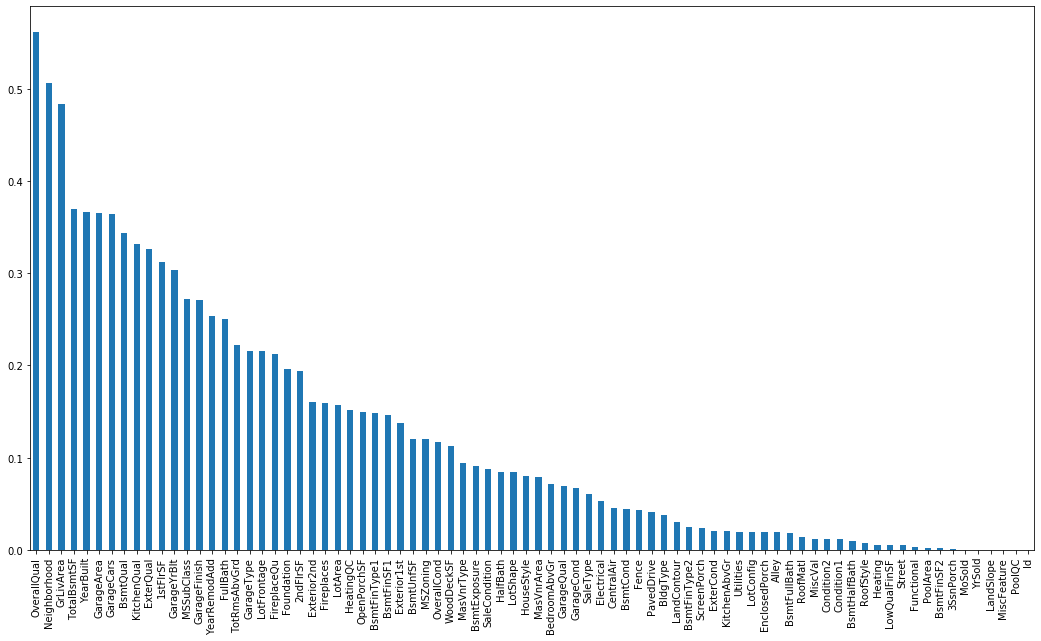

In [14]:
mi.sort_values(ascending=False).plot.bar(figsize=(18,10))

In [15]:
top_mi_score = (mi.values > 0.1)
print(mi[top_mi_score].sort_values(ascending=False))
top_cols = mi[top_mi_score].index
print(top_cols.sort_values(ascending=False))
print(len(top_cols))

OverallQual     0.561296
Neighborhood    0.506075
GrLivArea       0.483057
TotalBsmtSF     0.369649
YearBuilt       0.366303
GarageArea      0.365644
GarageCars      0.364183
BsmtQual        0.344020
KitchenQual     0.331390
ExterQual       0.326668
1stFlrSF        0.311931
GarageYrBlt     0.303236
MSSubClass      0.272413
GarageFinish    0.270415
YearRemodAdd    0.253018
FullBath        0.250208
TotRmsAbvGrd    0.222448
GarageType      0.215858
LotFrontage     0.215780
FireplaceQu     0.212010
Foundation      0.196500
2ndFlrSF        0.193702
Exterior2nd     0.160711
Fireplaces      0.158869
LotArea         0.157084
HeatingQC       0.151850
OpenPorchSF     0.149647
BsmtFinType1    0.148423
BsmtFinSF1      0.145995
Exterior1st     0.137999
BsmtUnfSF       0.120174
MSZoning        0.119962
OverallCond     0.116612
WoodDeckSF      0.112648
dtype: float64
Index(['YearRemodAdd', 'YearBuilt', 'WoodDeckSF', 'TotalBsmtSF',
       'TotRmsAbvGrd', 'OverallQual', 'OverallCond', 'OpenPorchSF',
  

In [16]:
final_dataset = train_df_encoded[top_cols]
print(final_dataset.shape)
final_dataset.head(3)

(1460, 34)


,MSSubClass,MSZoning,LotFrontage,LotArea,Neighborhood,OverallQual,OverallCond,YearBuilt,YearRemodAdd,Exterior1st,...,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF
0,60,3.0,65.0,8450,5.0,7,5,2003,2003,12.0,...,8,0,1,6,89.0,5,2,548,0,61
1,20,3.0,80.0,9600,24.0,6,8,1976,1976,8.0,...,6,1,4,6,62.0,5,2,460,298,0
2,60,3.0,68.0,11250,5.0,7,5,2001,2002,12.0,...,6,1,4,6,87.0,5,2,608,0,42


In [17]:
X_train, X_test, y_train, y_test = train_test_split(final_dataset,train_df_encoded['SalePrice'],test_size=0.3,random_state=42)

In [19]:

parameters = {'objective' :'reg:squarederror', 'colsample_bytree' : 0.3, 'learning_rate' : 0.1,
                'max_depth' : 5, 'alpha' : 10, 'n_estimator' : 10}
model_1 = train_xgb_model(parameters)
fit_model(model_1,X_train,y_train)
model_1.fit(X_train,y_train)
y_pred = predict_results(model_1,X_test)
rmse = calculate_rmse(model_1,y_test,y_pred)
print(rmse)

79000.37087550136


In [20]:
model_1.fit(X_train,y_train)
y_predicted = model_1.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_predicted))
print("RMSE: %f" % (rmse))

RMSE: 79000.370876


In [29]:
booster = ['gbtree','gblinear']
n_estimator = [50,100,200,1000,5000]
max_depth = [2,3,5,10,15,20,50]
learning_rate = [0.01,0.05,0.1,0.2,0.3,0.5,0.7]
min_child_weight = [1,5,10,15,20]
base_score=[0.25,0.5,0.75,1]
aplha = [5,10,15,50,100]
objective = ['reg:squarederror','reg:squaredlogerror']

hyperparameter_grid = {
    'n_estimator' : n_estimator,
    'objective' : objective,
    'max_depth' : max_depth,
    'learning_rate' : learning_rate,
    'min_child_weight' : min_child_weight,
    'booster' : booster,
    'alpha' : aplha
}


In [56]:
from sklearn.model_selection import GridSearchCV

In [30]:
model_tuned = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3,
                max_depth = 15, alpha = 15,n_estimator= 50 ,min_child_weight= 1,learning_rate= 0.3, booster= 'gbtree')

fit_model(model_tuned,X_train,y_train)
y_predicted = model_1.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_predicted))
print("RMSE: %f" % (rmse))

[17:55:50] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


RMSE: 79000.370876


In [31]:
gcv_1 = retune_model(model_1,hyperparameter_grid,X_train,y_train)
gcv_1.best_params_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   13.4s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   23.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   36.5s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:   54.1s
[Parallel(n_jobs=4)]: Done 874 tasks      | elapsed:  1.2min


[17:57:18] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:  1.4min finished


{'objective': 'reg:squarederror',
 'n_estimator': 200,
 'min_child_weight': 20,
 'max_depth': 10,
 'learning_rate': 0.3,
 'booster': 'gbtree',
 'alpha': 15}

In [24]:
X_train.isnull().sum().any()

False

In [35]:
model_2 = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.3,
                max_depth = 10, alpha = 15, n_estimators = 200,min_child_weight=20,booster='gbtree')

#model_2 = train_xgb_model(gcv_1.best_params_)
fit_model(model_2,X_train,y_train)
y_pred = predict_results(model_2,X_test)
rmse = calculate_rmse(model_2,y_test,y_pred)
print(rmse)

28517.728956528892
